In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [4]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 0
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 0
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['axes.labelpad'] = 10

In [5]:
bigfs = np.array([  4.08000000e+08,   1.42000000e+09,   4.57500000e+09,
         5.62500000e+09,   6.12500000e+09,   2.84000000e+10,
         4.41000000e+10,   7.04000000e+10,   1.43000000e+11,
         3.53000000e+11,   5.45000000e+11,   8.57000000e+11,
         1.25000000e+12,   2.14200000e+12,   3.00000000e+12])

In [6]:
bigdata = np.array([  1.69932098e+01,   1.88907320e+01,   1.80860056e+01,
         1.75061433e+01,   1.77466662e+01,   3.02925356e+01,
         2.67933107e+01,   2.61128183e+01,   8.87159628e+01,
         1.55447367e+03,   5.19328227e+03,   1.80570130e+04,
         4.39553844e+04,   7.45743649e+04,   4.19317749e+04])

In [7]:
bigerrs = np.array([  2.63219005e+00,   1.98121311e+00,   1.81,
         1.75,   1.76,   1.16505200e+00,
         1.09064996e+00,   1.29007422e+00,   4.88926217e+00,
         7.13450484e+01,   2.27787009e+02,   7.40880194e+02,
         1.14919453e+03,   1.56319215e+03,   8.11448565e+02])

In [8]:
beam = pi*((45./60.)*pi/180.)**2
beam2 = pi*((1./60./60.)*pi/180.)**2

In [11]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [12]:
pn = np.array([100., 1.e-3, 30.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]

In [13]:
pn2 = np.array([100., 1.e9, 5.e-10, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfs, bigdata, p0=pn2, sigma=bigerrs, absolute_sigma=True)
pfit4 = y[0]

In [16]:
figsize(8, 6)

In [17]:
def lnprior2(theta):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    if EM1 < 0 or EM1 > 1e4:
        return np.inf
    if EM2 < 1e4 or EM2 > 1e11:
        return np.inf
    if abeam < 0 or abeam > 1e-5:
        return np.inf
    if Ad < 0 or Ad > 10:
        return np.inf
    if Bd < 0 or Bd > 10:
        return np.inf
    if Td < 1 or Td > 100:
        return np.inf
    if np.abs(Acmb) > 10:
        return np.inf
    return 0.

In [18]:
def lnprob2(theta, x, y, yerr):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y, yerr)

In [19]:
def lnlike2(theta, x, y, yerr):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(x, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(x, A=Acmb) * beam
    model = fffit + fffit2 + dustfit + ccmb
    return -0.5 * np.sum((y-model)**2 / (yerr**2))

In [20]:
ndim, nwalkers = 7, 128
pos = [pfit4 * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [21]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(bigfs, bigdata, bigerrs))

In [22]:
sampler1.run_mcmc(pos, 2**16);

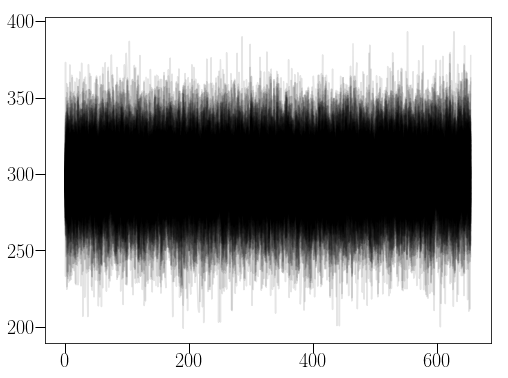

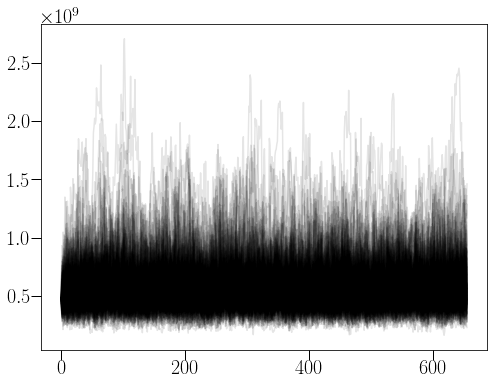

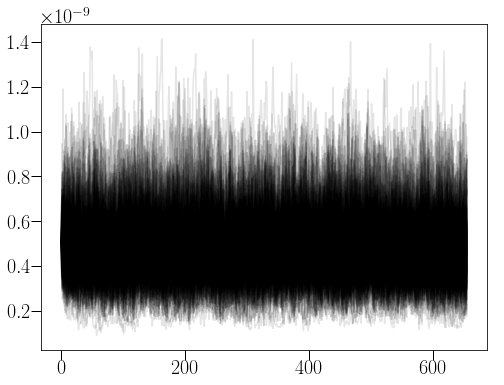

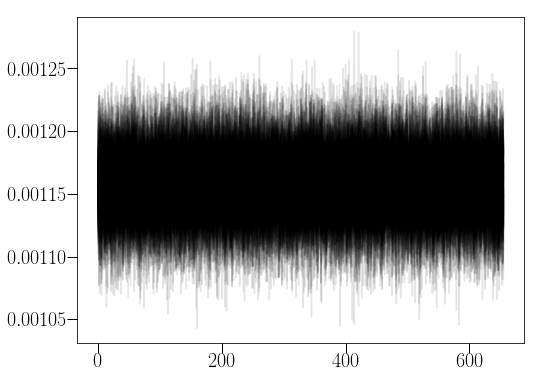

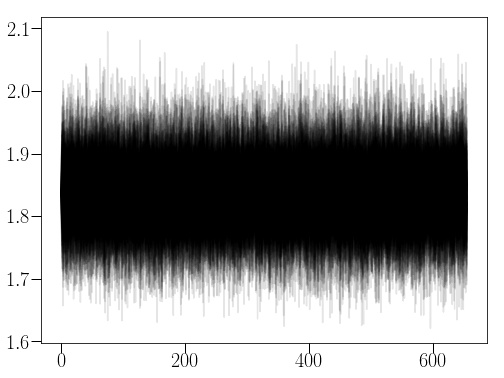

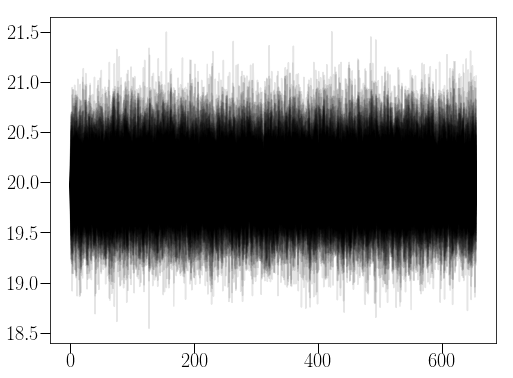

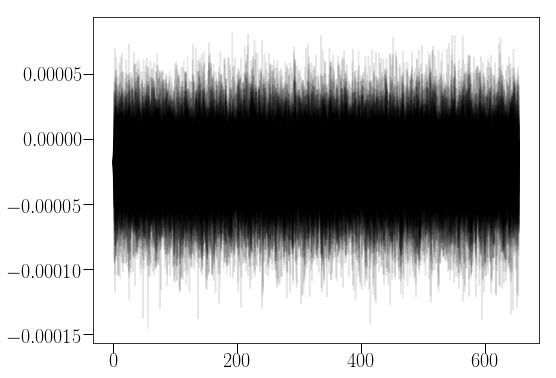

In [23]:
figsize(8, 6)
for k in range(ndim):
    figure()
    plot(sampler1.chain[:,::100,k].T, color='k', alpha=0.1);

In [24]:
samples1 = sampler1.chain[:, 10000:, :].reshape((-1, ndim))

In [57]:
datas = samples1.copy()

In [58]:
datas[:, 1] *= 1e-8
datas[:, 2] = np.sqrt( datas[:, 2] / pi) * 180. / pi * 60. * 60.
datas[:, 3] *= 1e6
datas[:, 6] *= 1e6

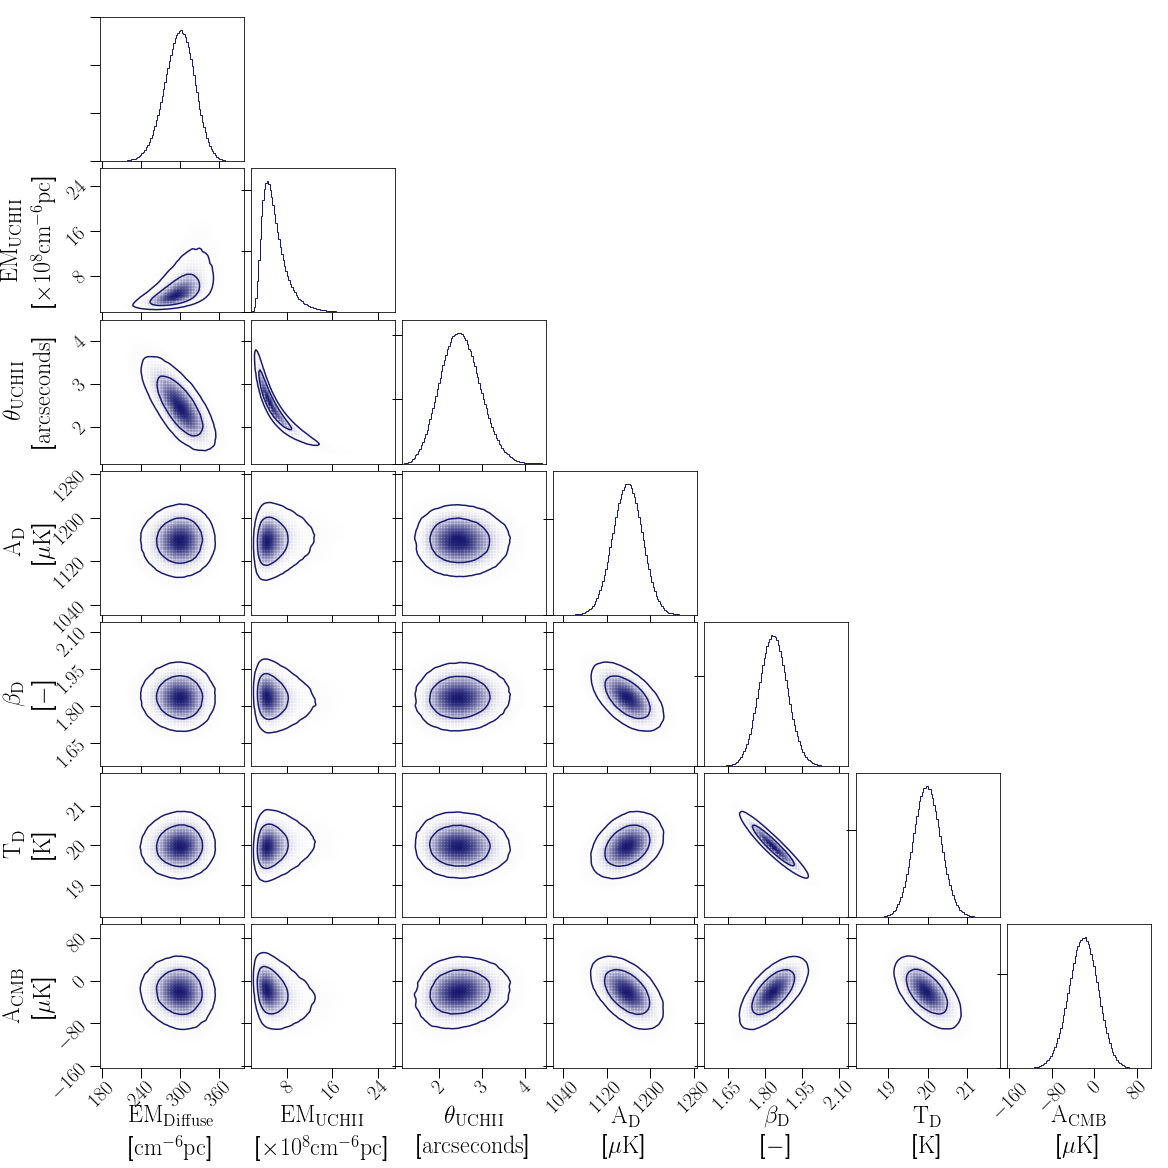

In [60]:
fig = corner.corner(datas, plot_datapoints=False, bins=100, levels=[0.68,0.95], smooth=1., \
                    labels=["$\mathrm{EM_{Diffuse}}$\n [$\mathrm{cm^{-6} pc}$]", 
                            "$\mathrm{EM_{UCHII}}$\n [$\\times 10^8 \mathrm{cm^{-6} pc}$]", 
                            "$\mathrm{\\theta_{UCHII}}$\n [$\mathrm{arcseconds}$]",
                            "$\mathrm{A_{D}}$\n [$\mathrm{\mu K}$]", 
                            "$\mathrm{\\beta_{D}}$\n [$-$]", 
                            "$\mathrm{T_{D}}$\n [$\mathrm{K}$]", 
                            "$\mathrm{A_{CMB}}$\n [$\mathrm{\mu K}$]"], \
                    color='midnightblue', max_n_ticks=4)
savefig('/home/mabitbol/GBT-S140/notebooks/UCHII_posterior.pdf', format='pdf', bbox_inches='tight')

In [61]:
np.save('mcmc_uchii_samples', datas)

In [62]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(datas, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb


[(299.89391514115096, 22.409134445457141, 23.891361466581372),
 (5.2712476084613247, 2.5290468706307729, 1.5059317860824688),
 (2.4936419901751812, 0.47321678779221799, 0.44442947595022586),
 (1157.8402347248434, 26.850020663686792, 27.17910486391861),
 (1.8339739977235667, 0.056943486522022413, 0.056188427270453367),
 (19.984524727774733, 0.3476591230661441, 0.33698733343834419),
 (-20.861361279597894, 27.300222769886936, 27.820398021574938)]

In [63]:
vds = zip(*np.percentile(datas, [16, 50, 84], axis=0))

In [67]:
names = ["EM1", "EM2", "abeam", "Ad", "Bd", "Td", "Acmb"]

In [74]:
for k in range(len(vds)):
    print names[k], '{0:1.3g}'.format(vds[k][1]), '{0:1.2g}'.format(vds[k][2] - vds[k][1]), \
          '{0:1.2g}'.format(vds[k][1] - vds[k][0], 1)

EM1 300 22 24
EM2 5.27 2.5 1.5
abeam 2.49 0.47 0.44
Ad 1.16e+03 27 27
Bd 1.83 0.057 0.056
Td 20 0.35 0.34
Acmb -20.9 27 28
